In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
# loading data
all_patents_df = pd.read_csv('../intermediate_csv_files/clean_raw_data.csv', parse_dates=['filing_date','grant_date'])

# delete extra "Unnamed" column
del all_patents_df['Unnamed: 0']

# create new column 'prosecution_period' as difference between grant date and filing date
all_patents_df['prosecution_period'] = all_patents_df.grant_date - all_patents_df.filing_date

# convert timedelta to integer number of days
all_patents_df.prosecution_period = all_patents_df.prosecution_period.apply(lambda x: x.days)

In [3]:
all_patents_df.application_type.value_counts()

utility    319983
design      30879
plant        1311
reissue       394
Name: application_type, dtype: int64

# (1) Is there a significant difference in prosecution period of utility patents versus non-utility patents (i.e., design and plant)?

**Note:** for the purposes of this analysis, the 394 *reissue* patents have been disregarded because reissue patents are procedural tools used for correcting errors in original patents and therefore comparing them on the basis of bibliographic information is not sound.

In [4]:
# calculate mean prosecution time for each application type
utility_mean_prosecution = all_patents_df[all_patents_df.application_type == 'utility']['prosecution_period'].mean()
design_mean_prosecution = all_patents_df[all_patents_df.application_type == 'design']['prosecution_period'].mean()
plant_mean_prosecution = all_patents_df[all_patents_df.application_type == 'plant']['prosecution_period'].mean()
reissue_mean_prosecution = all_patents_df[all_patents_df.application_type == 'reissue']['prosecution_period'].mean()

print("Mean prosecution period for utility patents:", utility_mean_prosecution)
print("Mean prosecution period for design patents:", design_mean_prosecution)
print("Mean prosecution period for plant patents:", plant_mean_prosecution)
print("Mean prosecution period for reissue patents:", reissue_mean_prosecution)

Mean prosecution period for utility patents: 1067.0334674029557
Mean prosecution period for design patents: 581.2163930179086
Mean prosecution period for plant patents: 647.5842868039664
Mean prosecution period for reissue patents: 1009.3807106598985


**Null Hypothesis ($H_0$):** there is no significant difference in prosecution period of utility patents versus non-utility patents.

**Alternate Hypothesis ($H_A$):** there is a significant difference in prosecution period of utility patents versus non-utility patents.

The formula for calculating the standard error of the sampling distributions of the difference in sample mean:

$$\sigma_{\bar{x_1}-\bar{x_2}}=\sqrt{\frac{\sigma_{x_1}^2}{n_1}+\frac{\sigma_{x_1}^2}{n_2}}$$

In the present case, $n_1=319,983$ for the sample of utility patents and $n_2=32,190$ for non-utility patents, however, we don't know the value of $\sigma_{x_1}^2$ or $\sigma_{x_2}^2$.  Because we have sufficiently large samples of utility and non-utility patents, we can use the sample variance for the utility and and non-utility samples. 

In [5]:
# combine plant and utility prosecution periods into single set
design_prosecution = np.array(all_patents_df[all_patents_df.application_type == 'design']['prosecution_period'])
plant_prosecution = np.array(all_patents_df[all_patents_df.application_type == 'plant']['prosecution_period'])
nonutility_prosecution = np.append(design_prosecution, plant_prosecution)

# calculate mean prosecution period for non-utility patents
nonutility_mean_prosecution = np.mean(nonutility_prosecution)

# calculate the observed difference between utility and non-utility prosecution period sample means
observed_diff_mean = utility_mean_prosecution - nonutility_mean_prosecution
observed_diff_mean

483.11411356636052

In [6]:
# calculate sample variance
utility_var_prosecution = np.var(all_patents_df[all_patents_df.application_type == 'utility']['prosecution_period'])
nonutility_var_prosecution = np.var(nonutility_prosecution)

# calculate the standard error of the sampling distribution of the difference in sample means
SE_diff_means = np.sqrt(utility_var_prosecution/319983 + nonutility_var_prosecution/32190)
SE_diff_means

1.6574282537247877

In [7]:
# calculate Z-score
z_score = observed_diff_mean/SE_diff_means
z_score

291.48417886604977

In [8]:
# calculate P-value
p_value = stats.norm.sf(abs(z_score))*2
p_value

0.0

**Conclusion:** our observed difference in mean prosecution period between utility and non-utility patents was approximately 483 days which is approximately 291 standard errors away from the theoretical difference if our $H_0$ were true, yielding a P-value that is incredibly small.  Therefore, we can confidently reject our null hypothesis in favor of $H_A$, i.e., that there is a significant difference in prosecution period between utility and non-utility patents.  Based on our observed data, it is apparent that utility patents take nearly twice as long in prosecution as their non-utility counterparts.

# (2) is there a significant difference in prosecution period between plant and design patents?

This will be the same two-sample hypothesis test performed above with respect to utility versus non-utility patents.

**$H_0$:** there is no significant difference in prosecution period for plant patents and design patents.

**$H_A$:** there is a significant difference in prosecution period for plant patents and design patents.

In [9]:
# calculate observed difference in means
observed_diff_mean = plant_mean_prosecution - design_mean_prosecution
observed_diff_mean

66.36789378605783

In [10]:
# calculate the sample variance
plant_prosecution_var = np.var(all_patents_df[all_patents_df.application_type == 'plant']['prosecution_period'])
design_prosecution_var = np.var(all_patents_df[all_patents_df.application_type == 'design']['prosecution_period'])

# calculate the standard error of the sampling distribution of the difference in sample means
SE_diff_means = np.sqrt(plant_prosecution_var/1311 + design_prosecution_var/30879)
SE_diff_means

4.7650951885196378

In [11]:
# calculate Z-score
z_score = observed_diff_mean/SE_diff_means
z_score

13.927926129567249

In [12]:
# calculate P-value
p_value = stats.norm.sf(abs(z_score))*2
p_value

4.2862127250455044e-44

**Conclusion:** our observed difference in mean prosecution period between plant and design patents was approximately 66 days which is approximately 14 standard errors away from the theoretical difference if our $H_0$ were true, yielding a P-value that is incredibly small (~4.286e-44).  Therefore, we can confidently reject our null hypothesis in favor of $H_A$, i.e., that there is a significant difference in prosecution period between plant and design patents.  Based on our observed data, it seems that plant patents take longer to prosecute.

# (3) is there a significant correlation between the number of claims and the prosecution period for utility patents?

**Note:** for the puropose of this analysis, we are only focusing on utility patents.  Plant and design patents only contain 1 claim due to the way they are drafted.  Therefore, the number of claims for those patents cannot have an observed impact on their individual prosecution periods.  Also, reissue patents have been omitted here for the reasons stated under item (1) above.

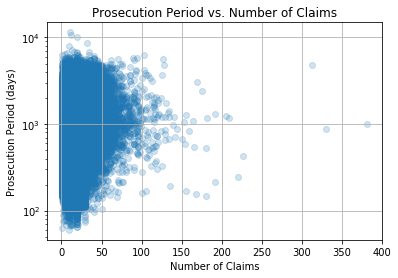

In [13]:
# filter for utility patents alone
utility_patents_df = all_patents_df[all_patents_df.application_type == 'utility']

# create arrays for data
x = np.array(utility_patents_df.number_of_claims)
y = np.array(utility_patents_df.prosecution_period)

# plot data
_ = plt.scatter(x, y, alpha=0.2)
_ = plt.grid(True)
_ = plt.yscale('log')
_ = plt.ylabel('Prosecution Period (days)')
_ = plt.xlabel('Number of Claims')
_ = plt.title('Prosecution Period vs. Number of Claims')
plt.show()

### Drawing Bootstrap Replicates to Visualize Regression

In [14]:
# function for pairs boostrap regression testing
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

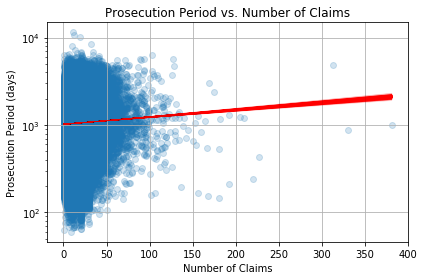

In [15]:
# draw 1000 pairs bootstrap replicates
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x, y, size=1000)

# plot data points 
_ = plt.scatter(x, y, alpha=0.2)
_ = plt.grid(True)
_ = plt.yscale('log')
_ = plt.ylabel('Prosecution Period (days)')
_ = plt.xlabel('Number of Claims')
_ = plt.title('Prosecution Period vs. Number of Claims')

# plot pairs bootstrap regression lines
x_params = np.array([0,np.max(x)])

for i in range(1000):
    _ = plt.plot(x_params, bs_slope_reps[i] * x_params + bs_intercept_reps[i], linewidth=0.5, alpha=0.1, color='red')

plt.tight_layout()
plt.show()

In [16]:
# function for calculating Pearson correlation coefficient
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

# calculate observed correlation coefficient
observed_r = pearson_r(x, y)
observed_r

0.038139166156679949

### Hypothesis Test for Significance of Correlation 

**$H_0$:** there is no statistically significant correlation between number of claims and prosecution period for utility patents (i.e., $\rho=0$).

**$H_A$:** there is a statistically significant correlation between number of claims and prosecution period for utility patents (i.e., $\rho\neq0$).

**Significance Level ($\alpha$):** 0.05 (5%)

Formula for t-statistic given the observed sample Pearson coefficient: $$t=r\sqrt{\frac{n-2}{1-r^2}}$$

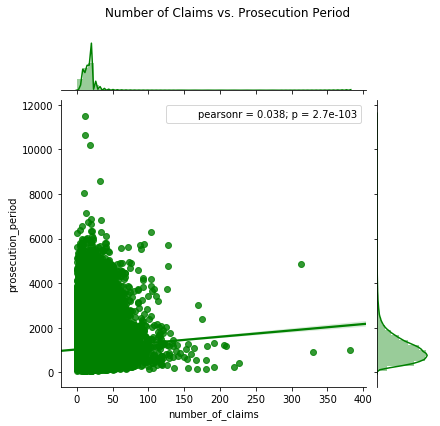

In [17]:
# visualization for relationship between number of claims and prosecution period
sns.jointplot(x="number_of_claims", y="prosecution_period", data=utility_patents_df, kind='reg', color='green')
plt.subplots_adjust(top=0.9)
f = plt.gcf()
f.suptitle('Number of Claims vs. Prosecution Period')
plt.show()

In [18]:
# formula for P-value of observed Pearson r value

def correlation_p_value(observed_r, sample_size):
    """function uses t-distribution to return two-tailed p-value of an observed correlation assuing rho=0"""
    # Calculate t statistic
    t_statistic = observed_r * np.sqrt((sample_size-2)/(1-observed_r**2))

    # calculate p-value from t_statistic
    p_value = stats.t.sf(np.abs(t_statistic), sample_size-2) * 2 # two-tailed formula
    return p_value

In [19]:
# compute P-value of observed Pearson r value if true Pearson r is 0 (i.e., Null Hypothesis)
correlation_p_value(observed_r, len(x))

2.6535033586623803e-103

**Conclusion:** with an incredibly small P-value (2.65e-103) we can conclude that the observed Pearson coefficient of correlation ($r$) is statistically significant and therefore reject $H_0$ in favor of $H_A$.  Put another way, the probability of getting a result as extreme as our observed $r$ if there is no true correlation in the population  ($\rho=0$) is extremely low (2.65e-103).  *However*, while there is a statistically significant correlation, the correlation is *very weak* at only 0.038.  Thus, the *practical significance* is very low here when it comes to predictive modeling.

# (4) Is there a significant correlation between the number of figures and the prosecution period for patents?

**Note:** for this analysis, all patent types will be included in the hypothesis test (including reissue patents) because each type can include different numbers of drawings and figures, even if it is a plant, design or procedural reissue patent.

**$H_0$:** there is no significant correlation between the number of figures/drawings in a patent and the duration of the prosecution period.

**$H_A$:** there is a statistically significant correlation between the number of figures/drawings and the duration of the prosecution period.

In [20]:
# use the function above to calculate observed_r
observed_r = pearson_r(all_patents_df['number-of-figures'], all_patents_df.prosecution_period)
observed_r

-0.01579173638438236

In [21]:
# use the function above to calculate the P-value of our observed_r
correlation_p_value(observed_r, len(all_patents_df))

6.7705264965498453e-21

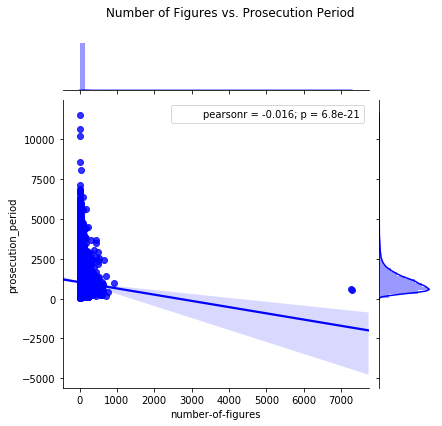

In [22]:
# visualization for relationship between number of figures and prosecution period
sns.jointplot(x="number-of-figures", y="prosecution_period", data=all_patents_df, kind='reg', color='blue')
plt.subplots_adjust(top=0.9)
f = plt.gcf()
f.suptitle('Number of Figures vs. Prosecution Period')
plt.show()

**Conclusion:** if our $H_0$ were true (i.e., if $\rho=0$), the probability (i.e., p-value) of observing a correlation as extreme as our observed Pearson r coefficient is 6.8e-21.  Therefore, we can reject $H_0$ in favor of $H_A$ and conclude that there is a significant correlation between the number of figures and the prosecution time.  With the current data set, we observe a *negative* Pearson coefficeint of approximately -0.016 which indicates that increasing the figure count correlates with a decrease in prosecution time.  *However*, as noted above with respect to the the previous analysis, the observed correlation is extremely weak and therefore of little practical significance when it comes to predictive modeling.